# IMPORTS & GLOBAL VARIABLES:
----

In [1]:
import numpy as np

from qibo import Circuit, gates

from helper_functions import random_state,print_random_state, print_theoretical_values, print_sampled_values, get_probabilities, execute_get_samples_and_plot, create_networkx_graph, print_networkx_graph, compute_network_path, create_secure_quantum_teleportation_path_circuit

# Number of `shots` we will use during this notebook:
shots = 10_000

# 1) RANDOM INITIAL STATE:
----

### Let's generate a `random state`, for `Alice`!

In [2]:
# Generate random state:
theta, phi = random_state()
alpha, beta = np.cos(theta/2), np.sin(theta/2)*np.exp(phi*1.j)*-1.j
prob_a, prob_b = np.cos(theta/2)**2, np.sin(theta/2)**2
print_random_state(theta, phi)

Theta: -2.1278333941896896, Phi: 0.046380911014222
State: alpha=0.48545158864270294  beta=(-0.040534603341820574+0.873323365664859j)
Probabilities: prob_a=0.23566324491572407  prob_b=0.7643367550842759



### Now let's do a small `circuit` and see its `results` and `probabilities`:

[Qibo 0.2.2|INFO|2023-11-08 12:59:41]: Using numpy backend on /CPU:0


Circuit:
q0: ─U1q─M─

THEORETICAL VALUES:
State: [ 0.48545159+0.j         -0.0405346 +0.87332337j]
Probabilities: [0.23566324 0.76433676]

SAMPLED VALUES:
Samples: [[0 1 1 ... 1 1 0]]
Frequencies: Counter({'1': 7602, '0': 2398})
Sampled probabilities: {'0': 0.2398, '1': 0.7602}


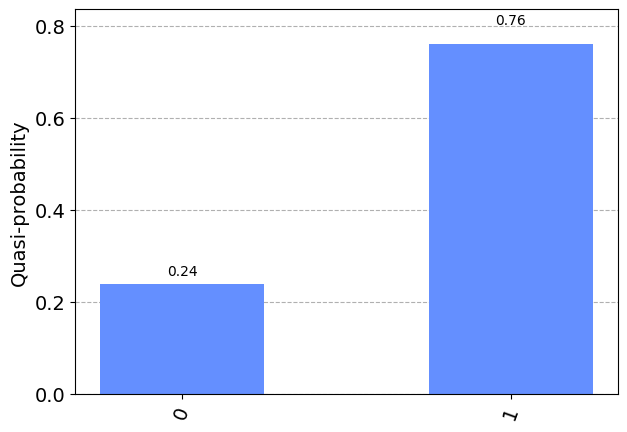

In [3]:
# Define a small circuit to check its probabilities:
c0 = Circuit(1)
c0.add(gates.U1q(q=0, theta=theta, phi=phi))
c0.add(gates.M(0))

# Plot the circuit:
print(f"Circuit:\n{c0.draw()}\n")

# Run the circuit:
result = c0(nshots=shots)

# Theoretical values:
state = result.state()
probabilities = result.probabilities()
print_theoretical_values(state, probabilities)

# Sampled values (with nshots):
# (possible because we have a Measurement gate!)
samples = np.stack(result.samples(), axis=1)
frequencies = result.frequencies()
sampled_probabilities = get_probabilities(frequencies)
print_sampled_values(samples, frequencies, sampled_probabilities)

# 2) TELEPORTATION CIRCUIT:
----

### Now we will generate the previously shown `circuit` for quantum teleportation:

In [4]:
# Define teleport circuit
c = Circuit(3)

# Initial Alice random state
c.add(gates.U1q(q=0, theta=theta, phi=phi))

# Initial Alice-Bob entangled state
c.add(gates.H(1))
c.add(gates.CNOT(1,2))

# Entanglement measure of Alice
c.add(gates.CNOT(0,1))
c.add(gates.H(0))
c.add(gates.M(0))
c.add(gates.M(1))

# From Alice's results, Bob does control Z's & X's:
c.add(gates.CZ(0,2))
c.add(gates.CNOT(1,2))
c.add(gates.M(2, register_name="measure"))

# Plot the circuit:
print(f"Circuit:\n{c.draw()}\n")

Circuit:
q0: ─U1q───o─H─M─o─────
q1: ─H───o─X─M───|─o───
q2: ─────X───────Z─X─M─



SAMPLED VALUES:
Samples: [[1 1 1 ... 1 0 0]]
Frequencies: Counter({'1': 7691, '0': 2309})
Sampled probabilities: {'0': 0.2309, '1': 0.7691}


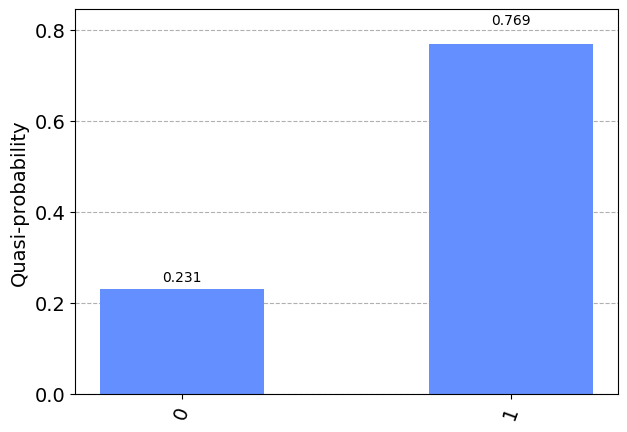

In [5]:
execute_get_samples_and_plot(circuit=c, shots=shots)

# 3) CONSECUTIVE QUANTUM TELEPORTS:
---
### Using an `intermediary B` we can connect `A` and `C`, that have never met before!

### First lets define the `graph` for such case:

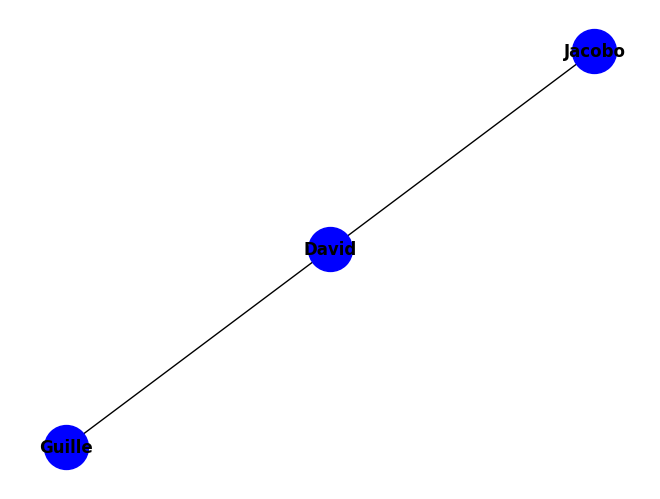

In [6]:
edges = {
    ("Guille", "David"): "",
    ("David", "Jacobo"): "",
}
G = create_networkx_graph(edges)
print_networkx_graph(G, edges)

### Now, lets do the `circuit`. Notice its the same, but with everything `duplicated`!

In [7]:
# Define teleport circuit
c = Circuit(5)

# Initial Alice random state
c.add(gates.U1q(q=0, theta=theta, phi=phi))

# Initial entangled states:
c.add(gates.H(1))
c.add(gates.CNOT(1,2))

c.add(gates.H(3))
c.add(gates.CNOT(3,4))

# Entanglement measurements
c.add(gates.CNOT(0,1))
c.add(gates.H(0))
c.add(gates.M(0))
c.add(gates.M(1))

c.add(gates.CNOT(2,3))
c.add(gates.H(2))
c.add(gates.M(2))
c.add(gates.M(3))

# From the obtained results, we do control Z's and X's to Bob:
c.add(gates.CZ(0,4))
c.add(gates.CNOT(1,4))

c.add(gates.CZ(2,4))
c.add(gates.CNOT(3,4))

c.add(gates.M(4, register_name="measure"))

# Plot the circuit:
print(f"Circuit:\n{c.draw()}\n")

Circuit:
q0: ─U1q───────o─H─M───────o─────────
q1: ─H───o─────X─M─────────|─o───────
q2: ─────X───────────o─H─M─|─|─o─────
q3: ───────H─o───────X─M───|─|─|─o───
q4: ─────────X─────────────Z─X─Z─X─M─



SAMPLED VALUES:
Samples: [[1 1 1 ... 1 1 0]]
Frequencies: Counter({'1': 7589, '0': 2411})
Sampled probabilities: {'0': 0.2411, '1': 0.7589}


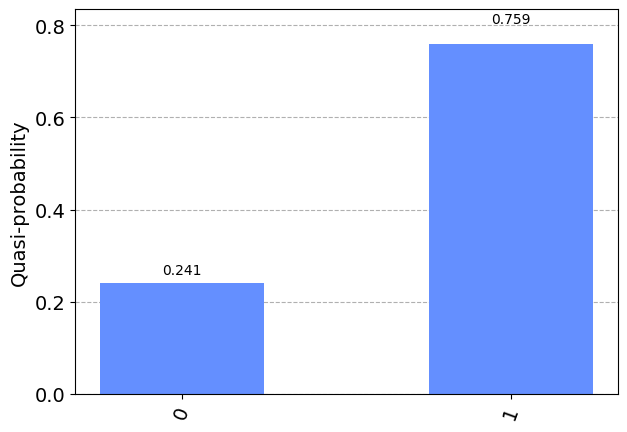

In [8]:
execute_get_samples_and_plot(circuit=c, shots=shots)

# 4) QUANTUM TELEPORTATION NETWORK:
---

### Now lets define a more complicated `graph` for a possible `quantum network`:

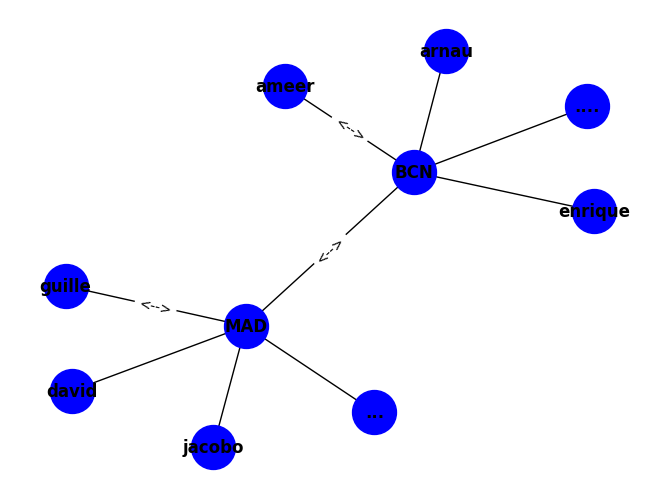

In [12]:
# Our secure quantum teleportation network is:
edges = {
    ("guille","MAD"): "<-->",
    ("david","MAD"): "",
    ("jacobo","MAD"): "",
    ("...", "MAD"): "",
    ("arnau", "BCN"): "",
    ("ameer", "BCN"): "<-->",
    ("enrique", "BCN"): "",
    ("....", "BCN"): "",
    ("BCN", "MAD"): "<-->",
}
graph_to_travel = create_networkx_graph(edges)
print_networkx_graph(graph_to_travel, edges)

### Now telling `who` wants to send a quantum state, and to who, `we compute the needed quantum circuit`!

In [13]:
# Guille wants to send a message to ameer:
sender = "guille"
receiver = "ameer"

# Search for the edges with shortest path
edges = compute_network_path(graph=graph_to_travel, sender=sender, receiver=receiver)
print(f"The path to follow is: {edges}")

# Create and plot the neede circuit:
automatic_circuit = create_secure_quantum_teleportation_path_circuit((theta,phi), edges)

# Plot the circuit:
print(f"Circuit:\n{automatic_circuit.draw()}\n")

The path to follow is: [('guille', 'MAD'), ('MAD', 'BCN'), ('BCN', 'ameer')]
Circuit:
q0: ─────────────U1q─o─H─M─────────────o─────────────
q1: ─H─o─────────────X─M───────────────|─o───────────
q2: ───X───────────────────o─H─M───────|─|─o─────────
q3: ─────H─o───────────────X─M─────────|─|─|─o───────
q4: ───────X─────────────────────o─H─M─|─|─|─|─o─────
q5: ─────────H─o─────────────────X─M───|─|─|─|─|─o───
q6: ───────────X───────────────────────Z─X─Z─X─Z─X─M─



SAMPLED VALUES:
Samples: [[1 1 1 ... 1 0 1]]
Frequencies: Counter({'1': 7640, '0': 2360})
Sampled probabilities: {'0': 0.236, '1': 0.764}


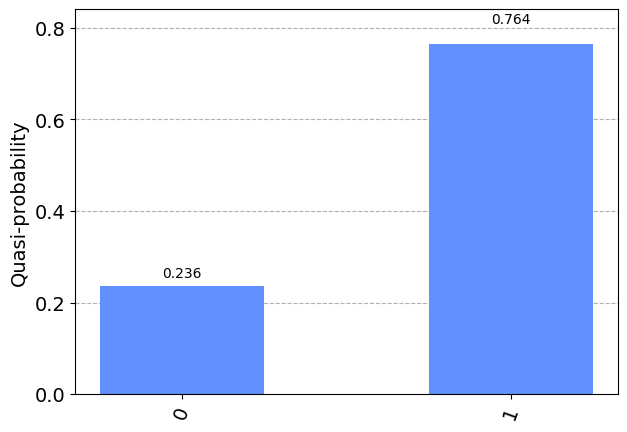

In [11]:
execute_get_samples_and_plot(circuit=c, shots=shots)

# IT WORKS PERFECTLY!!!